In [25]:

using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

## distance between least eigenvectors

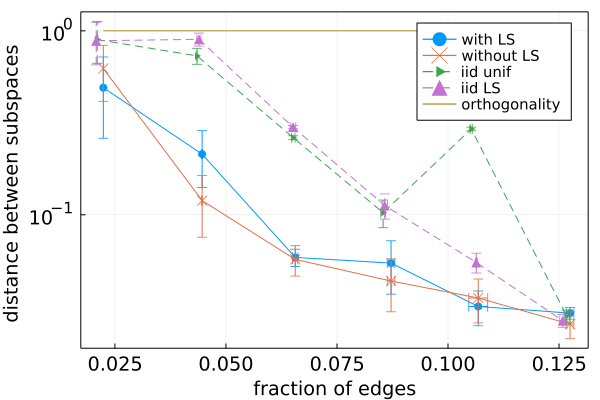

In [146]:
n = 100
p = 0.9
eta = 0.2
q = 0
n_batch = 6
n_rep = 3

batch = Int(floor(n))

type = "ERO"
#type = "MUN" 

rng = Random.default_rng();

#perm = randperm(rng,n)


if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta)
else
    meta_g = gen_graph_ero(rng, n, p, eta)
end

m = ne(meta_g)

B = magnetic_incidence(meta_g)
lev = leverage_score(B, q)
L = B * B'
lam,v = eigs(L, nev=1, which=:SM)

n_av = 1:n_batch

err_av = zeros(size(n_av))
err_av_lev = zeros(size(n_av))
err_av_iid_unif = zeros(size(n_av))
err_av_iid_lev = zeros(size(n_av))

err_av_std = zeros(size(n_av))
err_av_lev_std = zeros(size(n_av))
err_av_iid_unif_std = zeros(size(n_av))
err_av_iid_lev_std = zeros(size(n_av))

percent_edges = zeros(size(n_av))
percent_edges_std = zeros(size(n_av))

percent_edges_unif = zeros(size(n_av))
percent_edges_lev = zeros(size(n_av))

percent_edges_unif_std = zeros(size(n_av))
percent_edges_lev_std = zeros(size(n_av))

for i = 1:length(n_av)
    err_av_tp = zeros(n_rep,1)
    err_av_lev_tp = zeros(n_rep,1)
    err_av_iid_unif_tp = zeros(n_rep,1)
    err_av_iid_lev_tp = zeros(n_rep,1)
    percent_edges_tp = zeros(n_rep,1)

    percent_edges_unif_tp = zeros(n_rep,1)
    percent_edges_lev_tp = zeros(n_rep,1)

    for j = 1:n_rep

        avgL_lev = average_sparsifier(rng, meta_g, lev, q, n_av[i])

        avgL = average_sparsifier(rng, meta_g, nothing, q, n_av[i])

        avgL_iid_unif = average_sparsifier_iid(rng, meta_g, nothing, batch, n_av[i])

        avgL_iid_lev = average_sparsifier_iid(rng, meta_g, lev, batch, n_av[i])

        percent_edges_unif_tp[j] = nb_of_edges(avgL_iid_unif)/m
        percent_edges_lev_tp[j] = nb_of_edges(avgL_iid_lev)/m

        lam_av,v_av = eigs(avgL, nev=1, which=:SM)
        lam_av_lev,v_av_lev = eigs(avgL_lev, nev=1, which=:SM)

        F = eigen(avgL_iid_unif)
        V = F.vectors
        v_av_iid_unif = V[:,1]

        F = eigen(avgL_iid_lev)
        V = F.vectors
        v_av_iid_lev = V[:,1]

        scalar = v'*v_av
        err_av_tp[j] = 1- abs.(scalar[1])

        scalar = v'*v_av_lev
        err_av_lev_tp[j] = 1- abs.(scalar[1])

        scalar = v'*v_av_iid_unif
        err_av_iid_unif_tp[j] = 1- abs.(scalar[1])

        scalar = v'*v_av_iid_lev
        err_av_iid_lev_tp[j] = 1- abs.(scalar[1])

        percent_edges_tp[j] = nb_of_edges(avgL)/m;
    end
    err_av[i] = mean(err_av_tp)
    err_av_lev[i] = mean(err_av_lev_tp)
    err_av_iid_unif[i] = mean(err_av_iid_unif_tp)
    err_av_iid_lev[i] = mean(err_av_iid_lev_tp)

    err_av_std[i] = std(err_av_tp)
    err_av_lev_std[i] = std(err_av_lev_tp)
    err_av_iid_unif_std[i] = std(err_av_lev_tp)
    err_av_iid_lev_std[i] = std(err_av_lev_tp)
    
    percent_edges[i] = mean(percent_edges_tp)
    percent_edges_std[i] = std(percent_edges_tp)

    percent_edges_unif[i] = mean(percent_edges_unif_tp)
    percent_edges_unif_std[i] = std(percent_edges_unif_tp)

    percent_edges_lev[i] = mean(percent_edges_lev_tp)
    percent_edges_lev_std[i] = std(percent_edges_lev_tp)

end

plot(percent_edges,err_av_lev,xerror=percent_edges_std,yerror=err_av_lev_std, yaxis=:log,labels = "with LS",xlabel = "fraction of edges",ylabel = "distance between subspaces ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,err_av,xerror=percent_edges_std,yerror=err_av_std, yaxis=:log,labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,err_av_iid_unif,yerror=err_av_iid_unif_std, yaxis=:log,labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,err_av_iid_lev,yerror=err_av_iid_lev_std, yaxis=:log,labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,ones(size(n_av)),labels = "orthogonality",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box, yticks=[1e-3,1e-2,1e-1, 1e0])

In [147]:

plot(percent_edges,err_av_lev,xerror=percent_edges_std,yerror=err_av_lev_std, yaxis=:log,labels = "with LS",xlabel = "fraction of edges",ylabel = "distance between subspaces ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,err_av,xerror=percent_edges_std,yerror=err_av_std, yaxis=:log,labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,err_av_iid_unif,yerror=err_av_iid_unif_std, yaxis=:log,labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,err_av_iid_lev,yerror=err_av_iid_lev_std, yaxis=:log,labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,ones(size(n_av)),labels = "orthogonality",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box, yticks=[1e-3,1e-2,1e-1, 1e0])

foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"EigenDistance.pdf"
savefig(foldername*name)

## syncrank


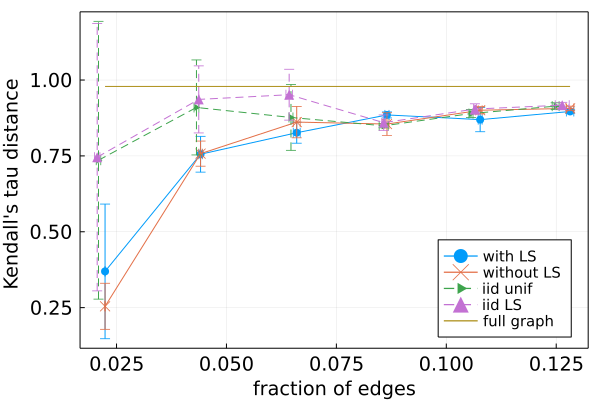

In [148]:
n = nv(meta_g)
q = 0
n_batch = 6
n_rep = 3
batch = Int(floor(n))

exact_ranking = collect(1:n)

B = magnetic_incidence(meta_g)
lev = leverage_score(B, q)
L = B * B'


n_av = 1:n_batch
tau_av_lev = zeros(size(n_av))
tau_av = zeros(size(n_av))
tau_av_iid_unif = zeros(size(n_av))
tau_av_iid_lev = zeros(size(n_av))


percent_edges = zeros(size(n_av))
percent_edges_unif = zeros(size(n_av))
percent_edges_lev = zeros(size(n_av))

tau_av_lev_std = zeros(size(n_av))
tau_av_std = zeros(size(n_av))
tau_av_iid_unif_std = zeros(size(n_av))
tau_av_iid_lev_std = zeros(size(n_av))


percent_edges_std = zeros(size(n_av))
percent_edges_unif_std = zeros(size(n_av))
percent_edges_lev_std = zeros(size(n_av))


for i = 1:length(n_av)

    tau_av_lev_tp = zeros(n_rep,1)
    tau_av_tp = zeros(n_rep,1)
    tau_av_iid_unif_tp = zeros(n_rep,1)
    tau_av_iid_lev_tp = zeros(n_rep,1)

    percent_edges_tp = zeros(n_rep,1)
    percent_edges_unif_tp = zeros(n_rep,1)
    percent_edges_lev_tp = zeros(n_rep,1)
    
    for j = 1:n_rep
        avgL_lev = average_sparsifier(rng, meta_g, lev, q, n_av[i])

        avgL = average_sparsifier(rng, meta_g, nothing, q, n_av[i])

        avgL_iid_unif = average_sparsifier_iid(rng, meta_g, nothing, batch, n_av[i])

        avgL_iid_lev = average_sparsifier_iid(rng, meta_g, lev, batch, n_av[i])

        percent_edges_tp[j] = nb_of_edges(avgL)/m;
        percent_edges_unif_tp[j] = nb_of_edges(avgL_iid_unif)/m
        percent_edges_lev_tp[j] = nb_of_edges(avgL_iid_lev)/m

        ranking = syncrank(avgL,meta_g,true)
        ranking_lev = syncrank(avgL_lev,meta_g,true)

        ranking_iid_unif = syncrank(avgL_iid_unif,meta_g,true)
        ranking_iid_lev = syncrank(avgL_iid_lev,meta_g,true)

        tau_av_tp[j] = corkendall(exact_ranking, ranking)
        tau_av_lev_tp[j] = corkendall(exact_ranking, ranking_lev)
        tau_av_iid_unif_tp[j] = corkendall(exact_ranking, ranking_iid_unif)
        tau_av_iid_lev_tp[j] = corkendall(exact_ranking, ranking_iid_lev)

    end
    tau_av[i] = mean(tau_av_tp)
    tau_av_lev[i] = mean(tau_av_lev_tp)
    tau_av_iid_unif[i] = mean(tau_av_iid_unif_tp)
    tau_av_iid_lev[i] = mean(tau_av_iid_lev_tp)

    percent_edges[i] = mean(percent_edges_tp)
    percent_edges_std[i] = std(percent_edges_tp)

    percent_edges_unif[i] = mean(percent_edges_unif_tp)
    percent_edges_unif_std[i] = std(percent_edges_unif_tp)

    percent_edges_lev[i] = mean(percent_edges_lev_tp)
    percent_edges_lev_std[i] = std(percent_edges_lev_tp)

    tau_av_std[i] = std(tau_av_tp)
    tau_av_lev_std[i] = std(tau_av_lev_tp)
    tau_av_iid_unif_std[i] = std(tau_av_iid_unif_tp)
    tau_av_iid_lev_std[i] = std(tau_av_iid_lev_tp)

end


ranking_full = syncrank(L,meta_g)
tau_full = corkendall(exact_ranking, ranking_full)


plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(n_av)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)

In [145]:
plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(n_av)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)
#yaxis!(:log)
foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"Kendall.pdf"
savefig(foldername*name)

In [24]:
plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "percentage of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 3)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 3)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 3,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 3,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(n_av)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)

foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"Kendall.pdf"
savefig(foldername*name)

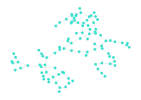

In [175]:
nbatch = 1
avgL = average_sparsifier(rng, meta_g, nothing, q, nbatch)

A = abs.(avgL - Diagonal(avgL))
A = (A.>0)

g = Graph(A)
#gplot(g, layout=random_layout)
#gplot(g, layout=spectral_layout)
#layout=(args...)->spring_layout(args...; C=20)
#gplot(g, layout=layout)
gplot(g)